In [1]:
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import os
from PIL import Image

import random
from IPython.display import display, clear_output
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import sqlite3

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score

In [2]:
class CroppedDataset(Dataset): # assume that all shapes are the same
    def __init__(self, folder_path, metadata_path, patch_size=(32, 32)):
        super().__init__()
        self.folder_path = folder_path
        self.image_pathes = os.listdir(folder_path)
        self.patch_size = patch_size
        
        conn = sqlite3.connect(metadata_path)
        metadata = pd.read_sql_query("SELECT * FROM Micrograph", conn)
        label_encoder = LabelEncoder()
        self.labels = label_encoder.fit_transform(metadata['primary_microconstituent'])
        
        img = plt.imread(os.path.join(self.folder_path, self.image_pathes[0]))
        img = img[:-38] ## cut the bottom line
        self.patches_i = int(img.shape[0] / self.patch_size[0])
        self.patches_j = int(img.shape[1] / self.patch_size[1])
        self.n_patches = self.patches_i * self.patches_j
        
        self.data = []
        self.means = []
        self.stds = []
        for path in self.image_pathes:
            img = plt.imread(os.path.join(self.folder_path, path))
            if len(img.shape) > 2:
                img = img[:, :, 0]
            img = img[:-38] ## cut the bottom line
            img = img / 255
            #img = img.round() ## binarization
            mean, std = img.mean(), img.std()
            if std == 0:
                std = 1
            
            #std = np.sqrt((img ** 2).mean()) ## 2 moment == 1 (not std)
            
            self.means.append(mean)
            self.stds.append(std)
            #img = (img - mean) / std
            #img = img / std
            self.data.append(img)

    def __len__(self):
        return len(self.image_pathes) * self.n_patches

    def __getitem__(self, index):
        img_index = index // self.n_patches
        #img = plt.imread(os.path.join(self.folder_path, self.image_pathes[img_index]))
        img = self.data[img_index]
        patch_index = index % self.n_patches ## select patch
        patch_i = patch_index // self.patches_j
        patch_j = patch_index % self.patches_j
        img = img[patch_i * self.patch_size[0]:(patch_i + 1) * self.patch_size[0],
                 patch_j * self.patch_size[1]:(patch_j + 1) * self.patch_size[1]]
        return img, self.means[img_index], self.stds[img_index], self.labels[img_index]

In [3]:
folder_path = '/kaggle/input/vkr-data/data2/micrographs/'
metadata_path = '/kaggle/input/vkr-data/data2/microstructures.sqlite'

dataset = CroppedDataset(folder_path, metadata_path, patch_size=(32, 32))

In [4]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size],
                                                           generator=torch.Generator().manual_seed(7))

In [5]:
import torchvision.transforms as T

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size = 512, shuffle = False, num_workers=2)

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_channels, latent_dim, output_channels, loss_cfs, num_classes):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, output_channels)
        self.classifier = Classifier(latent_dim, num_classes)
        self.loss_cfs = loss_cfs
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        reconstructed = self.decoder(z)
        logits = self.classifier(z)
        return reconstructed, mu, log_var, logits
    
    def loss(self, x, reconstructed, mu, log_var, logits, labels):
        sigma_x = 1.0e-1
        MSE = (torch.sum(((reconstructed - x) / sigma_x).pow(8.0))).pow(1.0/4.0) * (sigma_x ** 2)
        #MSE = nn.MSELoss()(reconstructed, x)
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        CE = nn.CrossEntropyLoss()(logits, labels)
        return MSE * self.loss_cfs[0] + KLD * self.loss_cfs[1] + CE * self.loss_cfs[2] 
        
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1),
        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 2 * 2, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2 * latent_dim)
        )
        self.linear_encoder = nn.Linear(2 * latent_dim, latent_dim)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.linear_encoder(x)
        return x[:, :self.latent_dim // 2], x[:, self.latent_dim // 2:]
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.linear_decoder = nn.Linear(latent_dim // 2, latent_dim)
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512 * 2 * 2),
        )
        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, output_channels, kernel_size=3, stride=1)
        )
    def forward(self, x):
        x = self.linear_decoder(x)
        x = self.fc(x)
        x = x.view(x.size(0), 512, 2, 2)
        x = self.conv(x)
        return x
    
    
class Classifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim // 2, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)


In [7]:
from IPython.display import display, clear_output
from ipywidgets import Output
from tqdm.auto import trange
from typing import Type, Union
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score

def predict(model, loader):
    model.eval()
    with torch.no_grad():
        original = []
        reconstructed = []
        true_labels = []
        predicted_labels = []
        for i, (x, mean, std, labels) in tqdm(enumerate(loader), leave=False, total=len(loader)):
            std = std[:, None, None, None]
            mean = mean[:, None, None, None]
            x = x.unsqueeze(1).float()
            x = x.to(device)
            reconstructed_x, mu, log, logits = model(x)
            reconstructed_x = reconstructed_x.cpu()
            original.append(x.cpu())
            reconstructed.append(reconstructed_x)
            
            probas = nn.Softmax(0)(logits)
            preds = probas.argmax(dim=-1)
            true_labels.append(labels)
            predicted_labels.append(preds)
    return original, reconstructed, true_labels, predicted_labels

def train_epoch(
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    val_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    verbose_num_iters: int = 32,
    device: torch.device = "cuda", 
    conditional: bool = False,
    epoch_num: int=0,
    train_mses: list = [],
    val_mses: list = [],
    train_accs: list = [],
    val_accs: list = []
):
    model.to(device)
    model.train()
    epoch_loss_trace = []
    
    display()
    out = Output()
    display(out)
    
    for i, (x, mean, std, labels) in tqdm(enumerate(train_dataloader), leave=False, total=len(train_dataloader)):
        x = x.unsqueeze(1).float()
        x = x.to(device)
        labels = labels.to(device)
        reconstructed_x, mu, log_var, logits = model(x)
        #loss = criterion(x, reconstructed_x)
        #if epoch_num % 2 == 0:
        #    model.loss_cfs = (2, 1 / 1e8 * 0.1, 0)
        #else:
        #    model.loss_cfs = (0, 1 / 1e8 * 0.1, 1 / 20)
        loss = model.loss(x, reconstructed_x, mu, log_var, logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss_trace.append(loss.item())

        if (i + 1) % verbose_num_iters == 0:
            with out:
                clear_output(wait=True)

                plt.figure(figsize=(10, 10))
                plt.subplot(3, 2, 1)
                plt.title("Current epoch loss", fontsize=22)
                plt.xlabel("Iteration", fontsize=16)
                plt.ylabel("Reconstruction loss", fontsize=16)
                plt.grid()
                plt.plot(epoch_loss_trace)
                
                plt.subplot(3, 2, 3)
                #plt.title('Epochs MSE')
                plt.plot(list(range(epoch_num)), train_mses, label='train')
                plt.plot(list(range(epoch_num)), val_mses, label='val')
                plt.ylabel("RMSE", fontsize=16)
                plt.legend()
                plt.grid()
                
                plt.subplot(3, 2, 5)
                plt.plot(list(range(epoch_num)), train_accs, label='train')
                plt.plot(list(range(epoch_num)), val_accs, label='val')
                plt.ylabel("Accuracy", fontsize=16)
                plt.legend()
                plt.grid()

                for j in range(3):
                    plt.subplot(2, 6, 4 + j)
                    plt.axis("off")
                    plt.imshow(x[j].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')

                    plt.subplot(2, 6, 10 + j)
                    plt.axis("off")
                    plt.imshow(reconstructed_x[j].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')

                plt.show()
    
    out.clear_output()
    
    original, reconstructed, true_labels, predicted_labels = predict(model, train_dataloader)
    train_mse = mean_squared_error(torch.cat(original).cpu().detach().numpy().flatten(),
               torch.cat(reconstructed).cpu().detach().numpy().flatten(), squared=False)
    train_mses.append(train_mse)
    train_acc = accuracy_score(torch.cat(true_labels).cpu().detach().numpy(),
               torch.cat(predicted_labels).cpu().detach().numpy())
    train_accs.append(train_acc)

    original, reconstructed, true_labels, predicted_labels = predict(model, val_dataloader)
    val_mse = mean_squared_error(torch.cat(original).cpu().detach().numpy().flatten(),
               torch.cat(reconstructed).cpu().detach().numpy().flatten(), squared=False)
    val_mses.append(val_mse)
    val_acc = accuracy_score(torch.cat(true_labels).cpu().detach().numpy(),
               torch.cat(predicted_labels).cpu().detach().numpy())
    val_accs.append(val_acc)
    
    
    return epoch_loss_trace, train_mses, val_mses, train_accs, val_accs


def train_model(
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer, 
    num_epochs: int = 5, 
    verbose_num_iters: int = 32,
    device: torch.device = "cuda",
    conditional: bool = False
):
    loss_trace = []
    train_mses = []
    val_mses = []
    train_accs = []
    val_accs = []
    for epoch in tqdm(range(num_epochs), desc="Epoch: ", leave=True):        
        epoch_loss_trace, train_mses, val_mses, train_accs, val_accs = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            optimizer=optimizer,
            verbose_num_iters=verbose_num_iters,
            device=device,
            conditional=conditional,
            epoch_num=epoch,
            train_mses=train_mses,
            val_mses=val_mses,
            train_accs=train_accs,
            val_accs=val_accs
        )
        
        loss_trace += epoch_loss_trace
        
    fig, ax = plt.subplots(3, figsize=(10, 12))
    ax[0].set_title("Total training loss", fontsize=22)
    ax[0].set_ylabel("Reconstruction loss", fontsize=16)
    ax[0].grid()
    ax[0].plot(loss_trace)
    
    ax[1].set_title("RMSE")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("RMSE")
    ax[1].plot(list(range(num_epochs)), train_mses, label='train')
    ax[1].plot(list(range(num_epochs)), val_mses, label='val')
    ax[1].grid()
    ax[1].legend()
    
    ax[2].set_title("Accuracy")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Accuracy")
    ax[2].plot(list(range(num_epochs)), train_accs, label='train')
    ax[2].plot(list(range(num_epochs)), val_accs, label='val')
    ax[2].grid()
    ax[2].legend()
    
    plt.show()
    
    model.eval()

In [8]:
d = torch.load('/kaggle/input/vkr-data/state_dict')

In [9]:
d['encoder.linear_encoder.weight'] = torch.zeros((1024, 2048))
d['encoder.linear_encoder.bias'] = torch.zeros(1024)
d['decoder.linear_decoder.weight'] = torch.zeros((1024, 512))
d['decoder.linear_decoder.bias'] = torch.zeros(1024)
d['classifier.classifier.0.weight'] = torch.zeros((7, 512))

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Output()

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

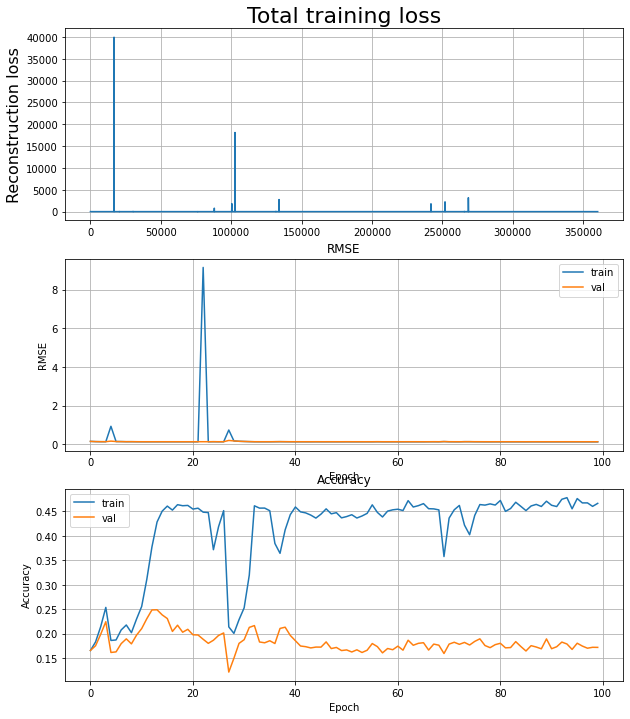

In [10]:
model = VariationalAutoencoder(1, 1024, 1, loss_cfs=(1, 1 / 1e8 * 0.1, 1 / 20), num_classes=7)
model.load_state_dict(d)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
criterion = nn.MSELoss()
train_model(model, train_dataloader, val_dataloader, optimizer, device=device, num_epochs=100, verbose_num_iters=64)

In [11]:
original, reconstructed, true_labels, predicted_labels = predict(model, val_dataloader)

  0%|          | 0/113 [00:00<?, ?it/s]

In [12]:
print('RMSE:', mean_squared_error(torch.cat(original).cpu().detach().numpy().flatten(),
               torch.cat(reconstructed).cpu().detach().numpy().flatten(), squared=False))
print('Accuracy:', accuracy_score(torch.cat(true_labels).cpu().detach().numpy(),
               torch.cat(predicted_labels).cpu().detach().numpy()))

RMSE: 0.13785015
Accuracy: 0.172528616024974


In [13]:
torch.save(model.state_dict(), 'state_dict')